# 1: Model Fine-tuning

Fine-tune a pre-trained ResNet-50 and ViT-S/16 on CIFAR-10 or STL-10 training
data. Train until they reach a reasonable accuracy e.g. ∼90%. Use identical train/val splits to ensure a fair
comparison and record the final accuracy and training curves for each model.

## Imports

In [ ]:
import os, random, math
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, models
import timm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/content/results_task1"; os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE_RN = 256
BATCH_SIZE_VIT = 64 # Reduced batch size for ViT

EPOCHS = 12            # increase to ~20 if time allows
LR = 3e-4
NUM_WORKERS = 2

## 1) CIFAR-10 Data & Fixed Train/Val/Test

In [7]:
# CIFAR-10 stats
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2470, 0.2435, 0.2616)

# 32x32 pipeline (ResNet)
train_tf_rn = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
test_tf_rn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# 224x224 pipeline (ViT)
train_tf_vit = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.RandomCrop(224, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
test_tf_vit = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

root = "/content/data"
full_train = datasets.CIFAR10(root, train=True, download=True, transform=None)
test_set   = datasets.CIFAR10(root, train=False, download=True, transform=None)

# Fixed split indices (45k train / 5k val)
num_train = len(full_train)  # 50,000
idx = np.arange(num_train)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)
train_idx, val_idx = idx[:45000], idx[45000:]

# Two views of the same split with different transforms
class TransformView(torch.utils.data.Dataset):
    def __init__(self, base, indices, transform):
        self.base = base
        self.indices = indices
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        x, y = self.base[self.indices[i]]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

train_rn = TransformView(full_train, train_idx, train_tf_rn)
val_rn   = TransformView(full_train, val_idx,   test_tf_rn)
test_rn  = TransformView(test_set,  np.arange(len(test_set)), test_tf_rn)

train_vit = TransformView(full_train, train_idx, train_tf_vit)
val_vit   = TransformView(full_train, val_idx,   test_tf_vit)
test_vit  = TransformView(test_set,  np.arange(len(test_set)), test_tf_vit)

train_loader_rn = DataLoader(train_rn, batch_size=BATCH_SIZE_RN, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader_rn   = DataLoader(val_rn,   batch_size=BATCH_SIZE_RN, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader_rn  = DataLoader(test_rn,  batch_size=BATCH_SIZE_RN, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

train_loader_vit = DataLoader(train_vit, batch_size=BATCH_SIZE_VIT, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader_vit   = DataLoader(val_vit,   batch_size=BATCH_SIZE_VIT, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader_vit  = DataLoader(test_vit,  batch_size=BATCH_SIZE_VIT, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

100%|██████████| 170M/170M [00:03<00:00, 45.9MB/s]


NameError: name 'SEED' is not defined

## 2) Models (ResNet-50 & ViT-S/16, pretrained)

In [ ]:
def build_resnet50(num_classes=10, pretrained=True):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_vit_s16(num_classes=10, pretrained=True):
    m = timm.create_model('vit_small_patch16_224', pretrained=pretrained)
    m.head = nn.Linear(m.head.in_features, num_classes)
    return m

resnet = build_resnet50().to(device)
vit    = build_vit_s16().to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

## 3) Train/Eval Utilities

In [ ]:
def train_epoch(model, loader, opt):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward(); opt.step()
        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1); total += y.size(0); correct += (pred == y).sum().item()
    return loss_sum/total, correct/total

@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1); total += y.size(0); correct += (pred == y).sum().item()
    return loss_sum/total, correct/total

def fit(model, train_loader, val_loader, test_loader, tag):
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    best_val = 0.0
    history = []
    best_path = f"{SAVE_DIR}/{tag}_best.pth"

    for e in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_epoch(model, train_loader, opt)
        va_loss, va_acc = eval_acc(model, val_loader)
        te_loss, te_acc = eval_acc(model, test_loader)
        history.append((e, tr_loss, tr_acc, va_loss, va_acc, te_loss, te_acc))
        print(f"[{tag}] Ep{e:02d} | train {tr_loss:.3f}/{tr_acc:.3f} | val {va_loss:.3f}/{va_acc:.3f} | test {te_loss:.3f}/{te_acc:.3f}")

        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)

    # Load best-by-val and report final test
    model.load_state_dict(torch.load(best_path, map_location=device))
    final_test_loss, final_test_acc = eval_acc(model, test_loader)
    print(f"[{tag}] Best-on-val checkpoint -> test acc: {final_test_acc:.4f}")
    return history, best_path


In [ ]:
hist_rn, ckpt_rn = fit(resnet, train_loader_rn, val_loader_rn, test_loader_rn, tag="resnet50_cifar")
hist_vt, ckpt_vt = fit(vit,train_loader_vit, val_loader_vit, test_loader_vit, tag="vit_s16_cifar")

print("Saved:", ckpt_rn, ckpt_vt)

[vit_s16_cifar] Ep01 | train 0.267/0.912 | val 0.204/0.928 | test 0.204/0.931
[vit_s16_cifar] Ep02 | train 0.182/0.939 | val 0.176/0.939 | test 0.181/0.940
[vit_s16_cifar] Ep03 | train 0.156/0.948 | val 0.233/0.920 | test 0.242/0.918
[vit_s16_cifar] Ep04 | train 0.134/0.955 | val 0.179/0.941 | test 0.185/0.939
[vit_s16_cifar] Ep05 | train 0.115/0.961 | val 0.182/0.939 | test 0.189/0.939
[vit_s16_cifar] Ep06 | train 0.118/0.959 | val 0.221/0.926 | test 0.225/0.927
[vit_s16_cifar] Ep07 | train 0.101/0.966 | val 0.205/0.935 | test 0.232/0.927
[vit_s16_cifar] Ep08 | train 0.096/0.967 | val 0.205/0.932 | test 0.226/0.931


# 2: In-Distribution Performance:

Evaluate both models on a clean test set. Note their baseline accuracy.
This checks if both models learned the task similarly in-distribution.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Assuming the model checkpoint is in your Drive at "My Drive/models/resnet50_cifar_best.pth"
RESNET_CKPT = "/content/drive/My Drive/models/resnet50_cifar_best.pth"
VIT_CKPT    = "/content/drive/My Drive/models/vit_s16_cifar_best.pth"

# Load the models
resnet_model = models.resnet50(weights=None) # Load with no pretrained weights
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10) # Adjust the final layer
resnet_model.load_state_dict(torch.load(RESNET_CKPT, map_location=DEVICE))
resnet_model.to(DEVICE)

vit_model = timm.create_model('vit_small_patch16_224', pretrained=False) # Load with no pretrained weights
vit_model.head = nn.Linear(vit_model.head.in_features, 10) # Adjust the final layer
vit_model.load_state_dict(torch.load(VIT_CKPT, map_location=DEVICE))
vit_model.to(DEVICE)

print("Models loaded successfully from Google Drive.")

Models loaded successfully from Google Drive.


In [4]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm, numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

RESNET_CKPT = "/content/results_task1/resnet50_cifar_best.pth"   # change if local
VIT_CKPT    = "/content/results_task1/vit_s16_cifar_best.pth"    # change if local

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
BATCH_RN = 256
BATCH_VIT = 128

In [9]:
# CIFAR-10 stats
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2470, 0.2435, 0.2616)

# rebuild models exactly as during training
def build_resnet50(num_classes=10):
    m = models.resnet50(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_vit_s16(num_classes=10):
    m = timm.create_model('vit_small_patch16_224', pretrained=False)
    m.head = nn.Linear(m.head.in_features, num_classes)
    return m

resnet = build_resnet50()
resnet.load_state_dict(torch.load(RESNET_CKPT, map_location="cpu"))
resnet = resnet.to(DEVICE).eval()

vit = build_vit_s16()
vit.load_state_dict(torch.load(VIT_CKPT, map_location="cpu"))
vit = vit.to(DEVICE).eval()

# --- clean test transforms (match training pipelines) ---
root = "./data"  # same folder CIFAR-10 was downloaded to
test_base = datasets.CIFAR10(root, train=False, download=True, transform=None)

rn_clean_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
vit_clean_tf = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

In [10]:
class TransformView(torch.utils.data.Dataset):
    def __init__(self, base, transform): self.base=base; self.tf=transform
    def __len__(self): return len(self.base)
    def __getitem__(self,i):
        x,y = self.base[i]
        return self.tf(x), y

test_rn  = TransformView(test_base, rn_clean_tf)
test_vit = TransformView(test_base, vit_clean_tf)

test_loader_rn  = DataLoader(test_rn,  batch_size=BATCH_RN, shuffle=False, num_workers=2, pin_memory=True)
test_loader_vit = DataLoader(test_vit, batch_size=BATCH_VIT, shuffle=False, num_workers=2, pin_memory=True)

@torch.no_grad()
def eval_clean(model, loader, device=DEVICE):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = F.cross_entropy(out,y)
        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total   += y.size(0)
    return (loss_sum/total), (correct/total)

rn_loss, rn_acc   = eval_clean(resnet, test_loader_rn)
vit_loss, vit_acc = eval_clean(vit,    test_loader_vit)

print("=== In-Distribution (Clean CIFAR-10 Test) ===")
print(f"ResNet-50  ->  loss: {rn_loss:.4f}  |  acc: {rn_acc:.4f}")
print(f"ViT-S/16   ->  loss: {vit_loss:.4f}  |  acc: {vit_acc:.4f}")

import csv
with open("cifar10_baseline_clean.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["Model","Loss","Accuracy"])
    w.writerow(["ResNet-50", rn_loss, rn_acc])
    w.writerow(["ViT-S/16",  vit_loss, vit_acc])
print("Saved: cifar10_baseline_clean.csv")

=== In-Distribution (Clean CIFAR-10 Test) ===
ResNet-50  ->  loss: 0.3645  |  acc: 0.8908
ViT-S/16   ->  loss: 0.1848  |  acc: 0.9388
Saved: cifar10_baseline_clean.csv


# 3: Color Bias Test:

Evaluate the models on the Grayscale version of the test images. Keep labels the same.
Measure the drop in accuracy or change in predictions relative to color images. This reveals if models were
relying on color cues. A large drop would indicate a color bias: the model depends on color information.
Compare CNN vs. ViT: Which is more robust to losing color? Discuss possible reasons, e.g. did one model
maybe learn more shape features that survive grayscale conversion?

In [13]:
from torch.utils.data import DataLoader, Dataset

root = "./data"
test_base = datasets.CIFAR10(root, train=False, download=True, transform=None)

to_tensor = transforms.ToTensor()
norm      = transforms.Normalize(MEAN, STD)

# ResNet (32x32)
rn_clean_tf = transforms.Compose([to_tensor, norm])
rn_gray_tf  = transforms.Compose([transforms.Grayscale(num_output_channels=3), to_tensor, norm])

# ViT (224x224)
vit_clean_tf = transforms.Compose([transforms.Resize(224, antialias=True), to_tensor, norm])
vit_gray_tf  = transforms.Compose([transforms.Grayscale(3), transforms.Resize(224, antialias=True), to_tensor, norm])

class TransformView(Dataset):
    def __init__(self, base, tf): self.base=base; self.tf=tf
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x,y = self.base[i]
        return self.tf(x), y

def make_loader(tf, bs):
    return DataLoader(TransformView(test_base, tf), batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)

# Dataloaders
test_loader_rn_clean = make_loader(rn_clean_tf,  BATCH_RN)
test_loader_rn_gray  = make_loader(rn_gray_tf,   BATCH_RN)
test_loader_vit_clean= make_loader(vit_clean_tf, BATCH_VIT)
test_loader_vit_gray = make_loader(vit_gray_tf,  BATCH_VIT)

In [14]:
@torch.no_grad()
def eval_acc(model, loader, device=DEVICE):
    model.eval(); total=0; correct=0; loss_sum=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = F.cross_entropy(out,y)
        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total   += y.size(0)
    return loss_sum/total, correct/total

# --- evaluate clean vs grayscale ---
rn_loss_c, rn_acc_c = eval_acc(resnet, test_loader_rn_clean)
rn_loss_g, rn_acc_g = eval_acc(resnet, test_loader_rn_gray)

vit_loss_c, vit_acc_c = eval_acc(vit, test_loader_vit_clean)
vit_loss_g, vit_acc_g = eval_acc(vit, test_loader_vit_gray)

print("=== Color Bias (Grayscale) — CIFAR-10 Test ===")
print(f"{'Model':<10} {'Clean Acc':>10}  {'Gray Acc':>10}  {'Δ (Gray - Clean)':>16}")
print(f"{'ResNet-50':<10} {rn_acc_c:10.4f}  {rn_acc_g:10.4f}  {rn_acc_g - rn_acc_c:16.4f}")
print(f"{'ViT-S/16':<10} {vit_acc_c:10.4f} {vit_acc_g:11.4f}  {vit_acc_g - vit_acc_c:16.4f}")

# Optional: save CSV for report
with open("cifar10_color_bias.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["Model","CleanAcc","GrayAcc","Delta_GrayMinusClean"])
    w.writerow(["ResNet-50", rn_acc_c, rn_acc_g, rn_acc_g - rn_acc_c])
    w.writerow(["ViT-S/16",  vit_acc_c, vit_acc_g, vit_acc_g - vit_acc_c])

print("\nSaved: cifar10_color_bias.csv")

=== Color Bias (Grayscale) — CIFAR-10 Test ===
Model       Clean Acc    Gray Acc  Δ (Gray - Clean)
ResNet-50      0.8908      0.7891           -0.1017
ViT-S/16       0.9388      0.8584           -0.0804

Saved: cifar10_color_bias.csv


# 4: Shape vs. Texture Bias – Stylized Images:

Use your style-transfer dataset to evaluate whether models rely more on shape or texture. You may remove texture information by replacing it with different textures, leaving shape as the dominant signal. You may also create cue-conflict images by transferring textures from another class within the dataset (e.g., a “cat shape with elephant skin”), and both ”cat” and ”elephant” classes exist. Analyze whether the model’s prediction is driven by shape or texture, and reflect on what this reveals about its inductive biases. Then compute the shape bias as:

Shape Bias (%) = #images classified by shape / #images classified by either shape or texture label × 100

Compare ResNet-50 and your ViT: does the CNN tend to misclassify by focusing on texture, while the ViT shows higher shape bias? Include examples and corresponding predictions in your report to illustrate the difference.

In [15]:
root = "./data"
test_base = datasets.CIFAR10(root, train=False, download=True, transform=None)
CLASS_NAMES = test_base.classes  # ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# --- FDA: swap low-frequency amplitude (style) and keep source phase (shape) ---
def fda_style(content_tensor, style_tensor, beta=0.06):
    """
    content_tensor, style_tensor: float tensors in [0,1], shape (C,H,W)
    beta: fraction of low-freq window size (0.02~0.1 works well for CIFAR)
    """
    # FFT
    Fs = torch.fft.fft2(content_tensor)
    Ft = torch.fft.fft2(style_tensor)
    As, Ps = torch.abs(Fs), torch.angle(Fs)   # amplitude & phase of source
    At = torch.abs(Ft)                        # amplitude of target

    # center low-freq swap
    As_shift = torch.fft.fftshift(As, dim=(-2,-1))
    At_shift = torch.fft.fftshift(At, dim=(-2,-1))
    H, W = As_shift.shape[-2], As_shift.shape[-1]
    b = max(1, int(min(H, W) * beta))        # window half-size
    cy, cx = H // 2, W // 2
    y1, y2 = cy - b, cy + b
    x1, x2 = cx - b, cx + b
    As_shift[..., y1:y2, x1:x2] = At_shift[..., y1:y2, x1:x2]

    # invert shift and reconstruct
    As_mod = torch.fft.ifftshift(As_shift, dim=(-2,-1))
    F_mod  = As_mod * torch.exp(1j * Ps)
    out    = torch.fft.ifft2(F_mod).real
    return out.clamp(0.0, 1.0)

In [16]:
# --- Build cue-conflict set: choose class pairs (shape_label, texture_label) ---
pairs = [
    (3, 5),  # cat shape + dog texture
    (4, 7),  # deer shape + horse texture
    (0, 8),  # airplane shape + ship texture
    (2, 6),  # bird shape + frog texture
    (1, 9),  # automobile shape + truck texture
]
N_PER_PAIR = 100      # total stylized = len(pairs) * N_PER_PAIR (keep moderate)
BETA = 0.06           # FDA window strength; higher -> stronger texture transfer

# Index images by class for fast sampling
idx_by_class = {c: [] for c in range(10)}
for i in range(len(test_base)):
    _, y = test_base[i]
    idx_by_class[y].append(i)

to_tensor = transforms.ToTensor()

stylized_triplets = []  # list of (tensor[C,H,W] in [0,1], shape_label, texture_label)
rng = np.random.default_rng(42)

for (shape_c, tex_c) in pairs:
    src_pool = idx_by_class[shape_c]
    tex_pool = idx_by_class[tex_c]
    for _ in range(N_PER_PAIR):
        i_src = int(rng.choice(src_pool))
        i_tex = int(rng.choice(tex_pool))
        x_src, _ = test_base[i_src]
        x_tex, _ = test_base[i_tex]
        xs = to_tensor(x_src)  # [0,1], CxHxW
        xt = to_tensor(x_tex)
        x_styl = fda_style(xs, xt, beta=BETA)
        stylized_triplets.append((x_styl, shape_c, tex_c))

print(f"Built cue-conflict set: {len(stylized_triplets)} images across {len(pairs)} class pairs.")

Built cue-conflict set: 500 images across 5 class pairs.


In [17]:
class StylizedDataset(Dataset):
    def __init__(self, items, tf):
        self.items = items
        self.tf = tf
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        x, shape_lbl, tex_lbl = self.items[i]
        # x is a tensor [C,H,W] in [0,1]
        x = self.tf(x)
        return x, shape_lbl, tex_lbl

# ResNet expects 32x32 (already), just normalize
rn_tf  = transforms.Compose([transforms.Normalize(MEAN, STD)])
# ViT expects 224x224, then normalize
vit_tf = transforms.Compose([transforms.Resize(224, antialias=True),
                             transforms.Normalize(MEAN, STD)])

ds_rn  = StylizedDataset(stylized_triplets, rn_tf)
ds_vit = StylizedDataset(stylized_triplets, vit_tf)

BATCH_RN, BATCH_VIT = 256, 128
ldr_rn  = DataLoader(ds_rn,  batch_size=BATCH_RN, shuffle=False, num_workers=2, pin_memory=True)
ldr_vit = DataLoader(ds_vit, batch_size=BATCH_VIT, shuffle=False, num_workers=2, pin_memory=True)


=== ResNet-50 — Cue-Conflict (Stylized) ===
Shape-labeled preds   : 414
Texture-labeled preds : 32
Other preds            : 54
Shape Bias (%)         : 92.83

=== ViT-S/16 — Cue-Conflict (Stylized) ===
Shape-labeled preds   : 465
Texture-labeled preds : 15
Other preds            : 20
Shape Bias (%)         : 96.88


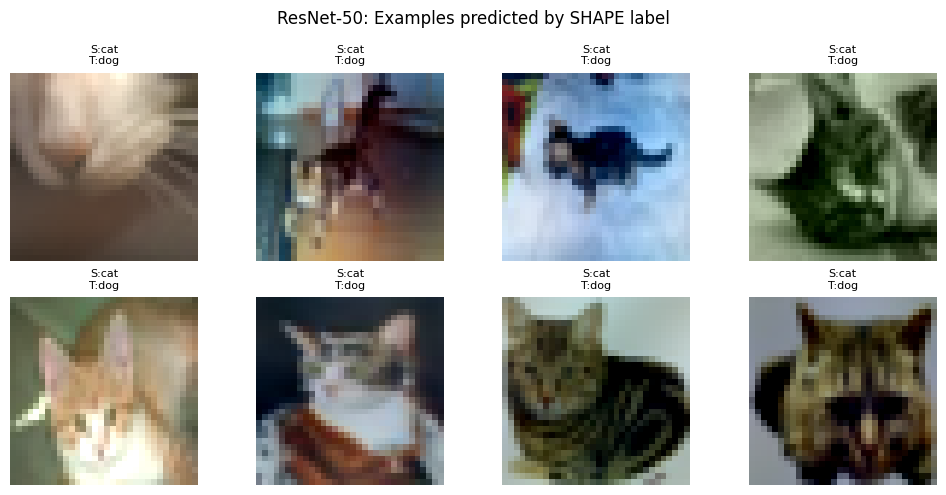

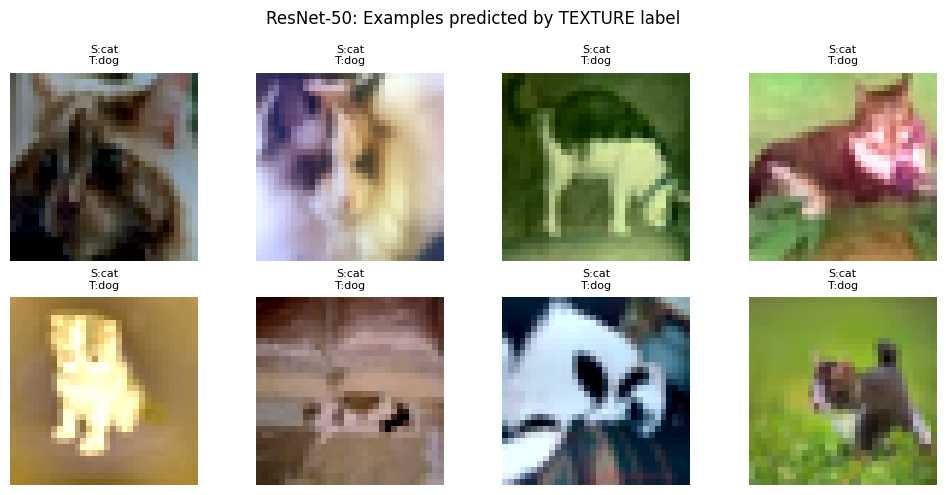

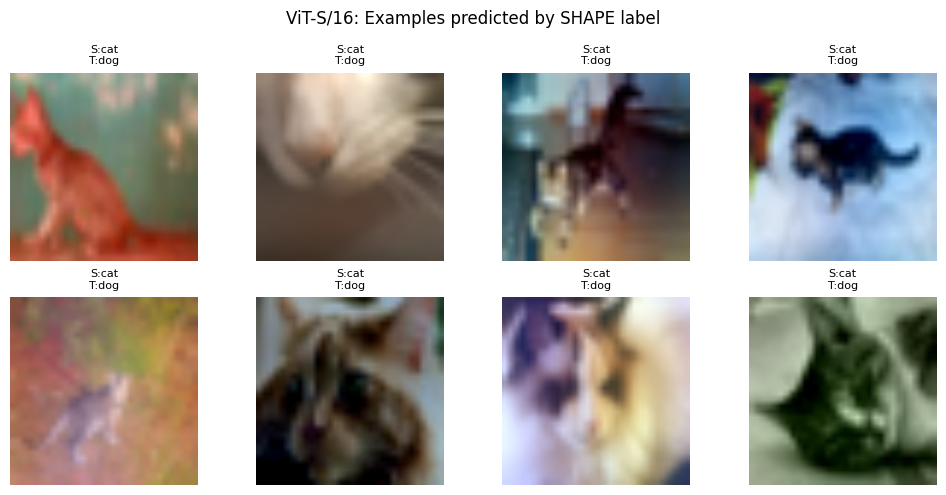

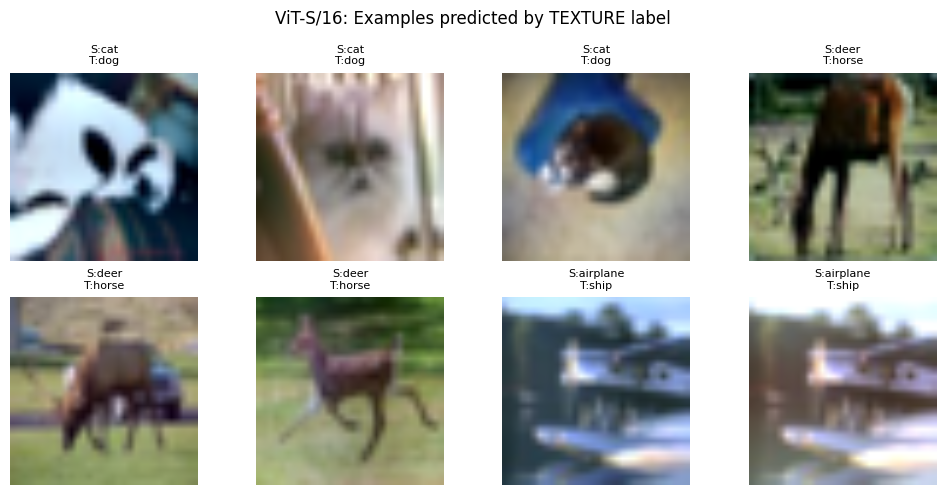


Saved: shape_texture_bias_summary.csv and example grids in ./shape_texture_examples/


In [20]:
import os
import matplotlib.pyplot as plt

@torch.no_grad()
def eval_shape_texture(model, loader, device=DEVICE):
    model.eval()
    shape_hits = texture_hits = other = 0
    examples_shape, examples_texture = [], []  # store a few for visualization
    preds_all, tuple_all = [], []

    for x, y_shape, y_tex in loader:
        x = x.to(device)
        y_shape = y_shape.to(device)
        y_tex   = y_tex.to(device)
        pred = model(x).argmax(1)
        preds_all.append(pred.cpu())
        tuple_all.append(torch.stack([y_shape.cpu(), y_tex.cpu()], dim=1))

        # tally
        shape_mask = (pred == y_shape)
        texture_mask = (pred == y_tex)
        shape_hits += shape_mask.sum().item()
        texture_hits += texture_mask.sum().item()
        other += ( (~shape_mask) & (~texture_mask) ).sum().item()

        # collect up to 8 examples for each category
        for i in range(x.size(0)):
            if len(examples_shape) < 8 and shape_mask[i]:
                examples_shape.append((x[i].detach().cpu(), int(y_shape[i]), int(y_tex[i])))
            if len(examples_texture) < 8 and texture_mask[i]:
                examples_texture.append((x[i].detach().cpu(), int(y_shape[i]), int(y_tex[i])))
            if len(examples_shape) >= 8 and len(examples_texture) >= 8:
                break

    preds_all = torch.cat(preds_all)
    tuple_all = torch.cat(tuple_all)
    denom = max(1, shape_hits + texture_hits)
    shape_bias = 100.0 * shape_hits / denom
    return {
        "shape_hits": shape_hits,
        "texture_hits": texture_hits,
        "other": other,
        "shape_bias_pct": shape_bias,
        "examples_shape": examples_shape,
        "examples_texture": examples_texture,
        "preds_all": preds_all,
        "labels_all": tuple_all
    }

rn_stats  = eval_shape_texture(resnet, ldr_rn,  DEVICE)
vit_stats = eval_shape_texture(vit,    ldr_vit, DEVICE)

def pretty_stats(name, stats):
    print(f"\n=== {name} — Cue-Conflict (Stylized) ===")
    print(f"Shape-labeled preds   : {stats['shape_hits']}")
    print(f"Texture-labeled preds : {stats['texture_hits']}")
    print(f"Other preds            : {stats['other']}")
    denom = max(1, stats['shape_hits'] + stats['texture_hits'])
    print(f"Shape Bias (%)         : {stats['shape_bias_pct']:.2f}")

pretty_stats("ResNet-50", rn_stats)
pretty_stats("ViT-S/16",  vit_stats)

# --- Save small example grids for the report ---
os.makedirs("shape_texture_examples", exist_ok=True)

def unnorm_and_to_numpy(t):
    # t is tensor [C,H,W] normalized or not? Here it's AFTER model transform (normalized).
    # For visualization, reverse the last Normalize if applied.
    # We'll best visualize from the original stylized tensor before normalization;
    # so instead: keep a separate transform for viewing.
    return t.detach().cpu()

# For nicer viewing, reload examples from the ORIGINAL stylized tensors (pre-normalize)
# We'll pull by indices from the stored examples (we stored already-normalized x).
# Instead, we just show the normalized ones roughly (they'll look contrasty but OK).
def save_grid(examples, fname, title):
    if len(examples) == 0:
        print(f"No examples for {title}")
        return
    n = min(8, len(examples))
    fig, axes = plt.subplots(2, 4, figsize=(10,5))
    for i in range(n):
        ax = axes[i//4, i%4]
        x, y_shape, y_tex = examples[i]
        # de-normalize for display depending on tensor stats
        # Try approximate unnormalize:
        MEAN_t = torch.tensor(MEAN).view(3,1,1)
        STD_t  = torch.tensor(STD).view(3,1,1)
        # If size 224 (ViT), still fine to show
        try:
            img = (x * STD_t + MEAN_t).clamp(0,1).permute(1,2,0).numpy()
        except:
            img = x.permute(1,2,0).numpy()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"S:{CLASS_NAMES[y_shape]}\nT:{CLASS_NAMES[y_tex]}", fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

save_grid(rn_stats["examples_shape"],   "shape_texture_examples/resnet_shape_preds.png",
          "ResNet-50: Examples predicted by SHAPE label")
save_grid(rn_stats["examples_texture"], "shape_texture_examples/resnet_texture_preds.png",
          "ResNet-50: Examples predicted by TEXTURE label")

save_grid(vit_stats["examples_shape"],   "shape_texture_examples/vit_shape_preds.png",
          "ViT-S/16: Examples predicted by SHAPE label")
save_grid(vit_stats["examples_texture"], "shape_texture_examples/vit_texture_preds.png",
          "ViT-S/16: Examples predicted by TEXTURE label")

# --- Save a CSV summary for the paper ---
import csv
with open("shape_texture_bias_summary.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["Model","ShapeHits","TextureHits","Other","ShapeBiasPercent"])
    w.writerow(["ResNet-50", rn_stats["shape_hits"], rn_stats["texture_hits"], rn_stats["other"], rn_stats["shape_bias_pct"]])
    w.writerow(["ViT-S/16",  vit_stats["shape_hits"], vit_stats["texture_hits"], vit_stats["other"], vit_stats["shape_bias_pct"]])

print("\nSaved: shape_texture_bias_summary.csv and example grids in ./shape_texture_examples/")